In [1]:
data_root = 'data/drums/'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle
from os.path import join
from utils import *
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [8]:
%time fingerprints = np.load(join(data_root, 'fingerprints.npy'))
img_channels = fingerprints.shape[1]
img_rows, img_cols = fingerprints.shape[1:]
print fingerprints.shape

CPU times: user 651 µs, sys: 8.17 ms, total: 8.82 ms
Wall time: 7.99 ms
(4083, 32, 32)


In [5]:
with open(data_root + 'synset_examples.pkl', 'rb') as f:
    synset_examples = pickle.load(f)
with open(data_root + 'synsets.pkl', 'rb') as f:
    synsets = pickle.load(f)
nb_classes = len(synsets)

In [6]:
labels = [[] for image in fingerprints]
for i, synset_example in enumerate(synset_examples):
    for example in synset_example:
        labels[example].append(i)

In [7]:
# take a sample of the data with even chunks for each class
# print(np.min([len(e) for e in synset_examples])) # minimum number of samples per class
def get_data(samples_per_class=100):
    X_train = []
    y_classes = []
    for examples in synset_examples:
        examples_list = list(examples)
        np.random.shuffle(examples_list)
        for i in examples_list[:samples_per_class]:
            X_train.append(fingerprints[i])
            y_classes.append(labels[i])
    X_train = np.asarray(X_train)
    y_train = np.zeros((len(y_classes), nb_classes), dtype=np.float32)
    for i, w in enumerate(y_classes):
        y_train[i, w] = 1.
    return X_train, y_train

In [8]:
X_train, y_train = get_data()
print(X_train.dtype, X_train.shape, X_train.min(), X_train.max())
print(y_train.dtype, y_train.shape)

float32 (12800, 1, 32, 32) 0.0 1.0
float32 (12800, 128)


In [9]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 32, 32, 32)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 32, 32, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 32, 30, 30)  9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)          (None, 32, 30, 30)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
from keras import backend as K

batch_size = 32
nb_epoch = 10
nb_slices = 48
lr = 0.001
decay = 0.99

for d in range(nb_slices):
    X_train, y_train = get_data()
    print('Learning rate', lr)
    K.set_value(model.optimizer.lr, lr)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          verbose=2,
          shuffle=True)
    lr *= decay

# # this will do preprocessing and realtime data augmentation
# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=0,  # randomly rotate fingerprints in the range (degrees, 0 to 180)
#     width_shift_range=8./img_cols,  # randomly shift fingerprints horizontally (fraction of total width)
#     height_shift_range=2./img_rows,  # randomly shift fingerprints vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip fingerprints
#     vertical_flip=False)  # randomly flip fingerprints

# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)

# # fit the model on the batches generated by datagen.flow()
# model.fit_generator(datagen.flow(X_train, y_train,
#                         batch_size=batch_size),
#                     samples_per_epoch=X_train.shape[0],
#                     nb_epoch=nb_epoch)

Learning rate 0.001
Epoch 1/10
 1344/12800 [==>...........................] - ETA: 40s - loss: 12.0682 - acc: 0.1600

In [77]:
model.evaluate(X_train, y_train)

12800/12800 [==============================] - 9s     


[8.1382808107137681, 0.31015625000000002]

In [18]:
predicted = model.predict(fingerprints)

In [43]:
def matching_layers(model, name):
    return [l for l in model.layers if l.name == name]
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [23]:
from keras import backend as K
get_encoding = K.function([model.layers[0].input, K.learning_phase()],
                          [matching_layers(model, 'activation_5')[0].output])

In [46]:
encoding_pieces = [get_encoding([x, 1])[0] for x in chunks(fingerprints, 1024)]
encoding = np.vstack(encoding_pieces)
encoding.shape

(44290, 512)

In [47]:
np.save(data_root + 'encoded_mc.npy', encoding)

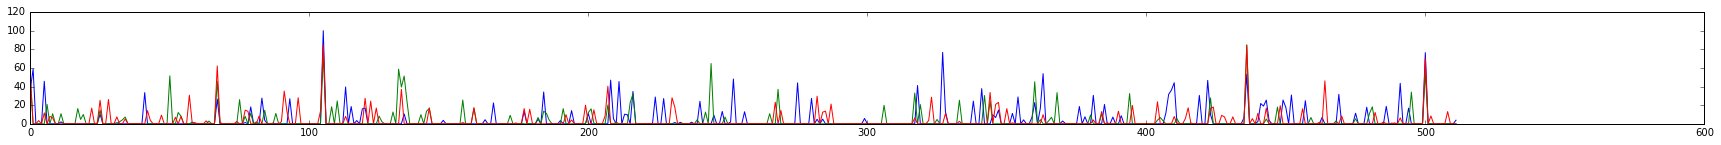

In [42]:
plt.figure(figsize=(30,2))
plt.plot(encoded_output[:3].T)
plt.show()

In [108]:
np.save(data_root + 'predicted_mc.npy', predicted)

In [10]:
# json_string = model.to_json()
# open(data_root + 'image_mc.json', 'w').write(json_string)
# model.save_weights(data_root + 'image_mc.h5')
# from keras.models import model_from_json
# model = model_from_json(open(data_root + 'image_mc.json').read())
model.load_weights(data_root + 'image_mc.h5')

[76] ['phoneme', 'syllables']


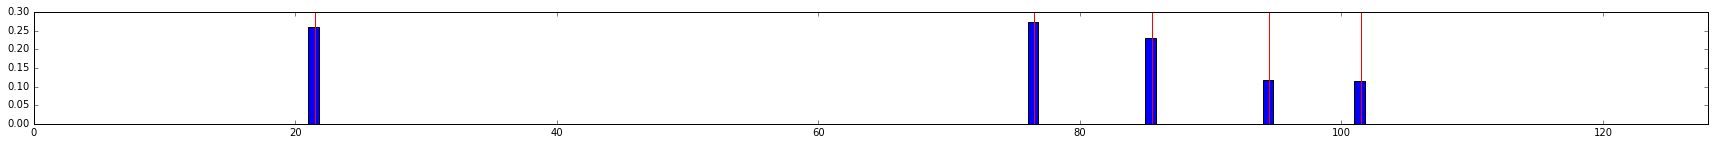

[94] ['short']


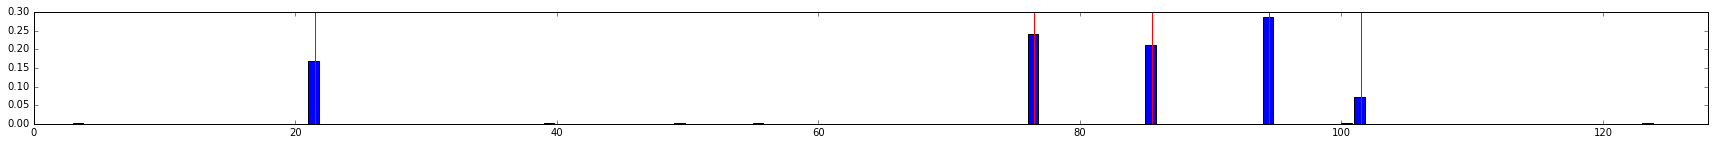

[99] ['snare', 'snares']


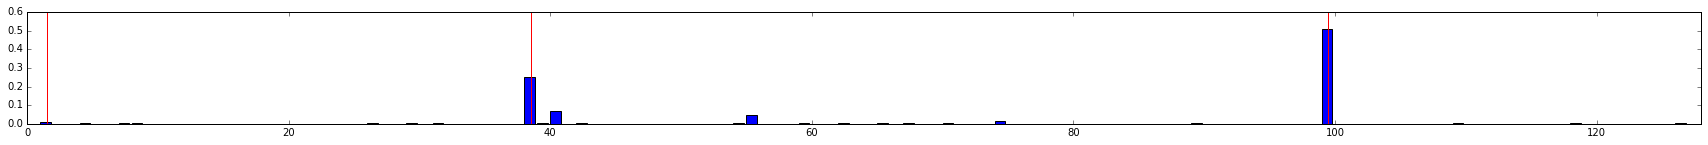

[94] ['short']


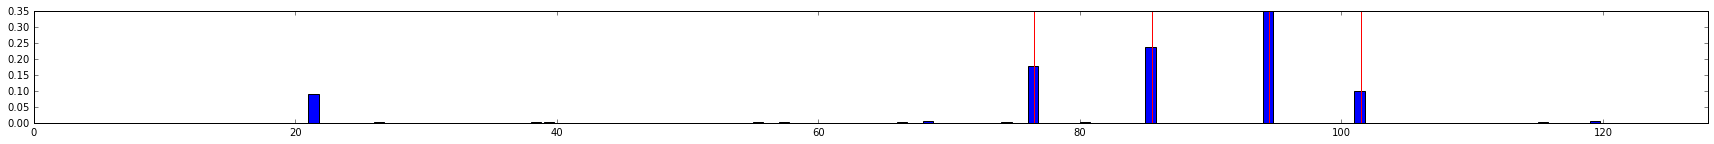

[94] ['short']


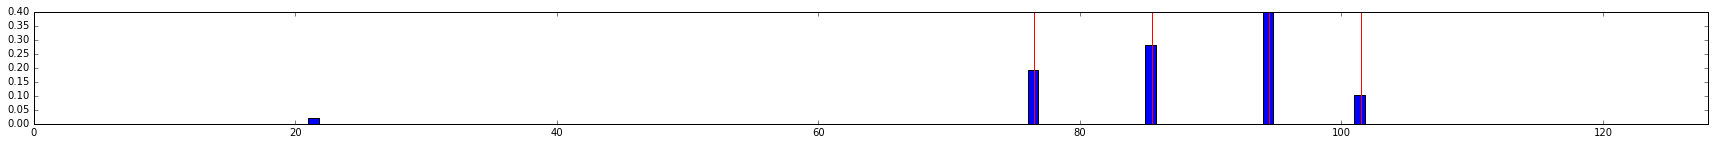

[76] ['phoneme', 'syllables']


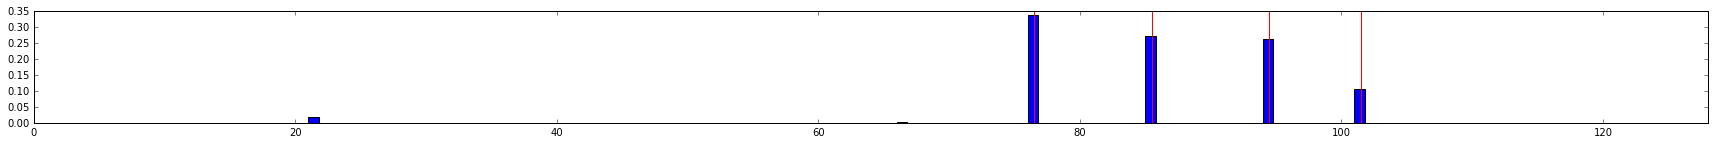

[94] ['short']


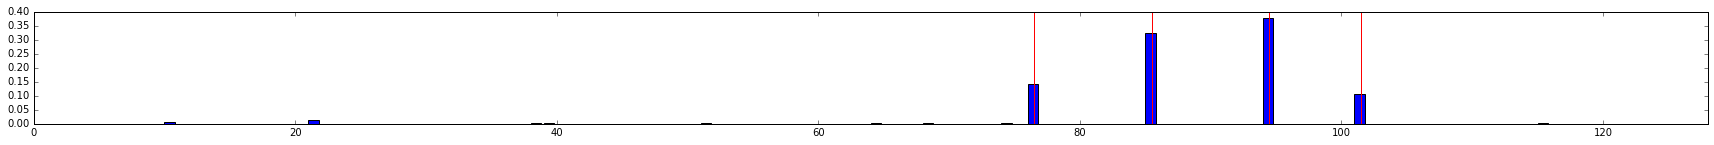

[38] ['drum', 'drums', 'drumset', 'drumkit', 'kit']


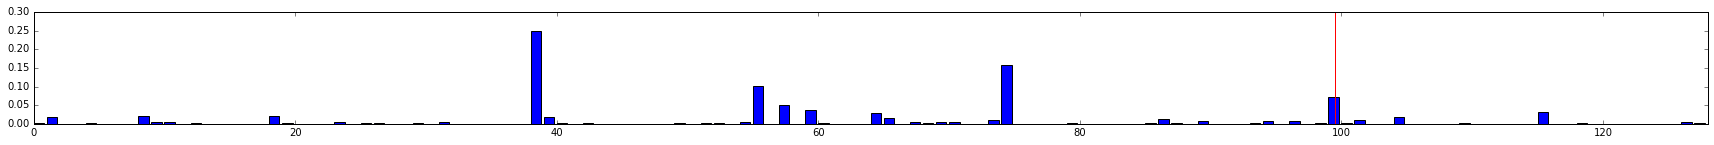

[65] ['machine', 'machinery', 'mechanic', 'mechanical']


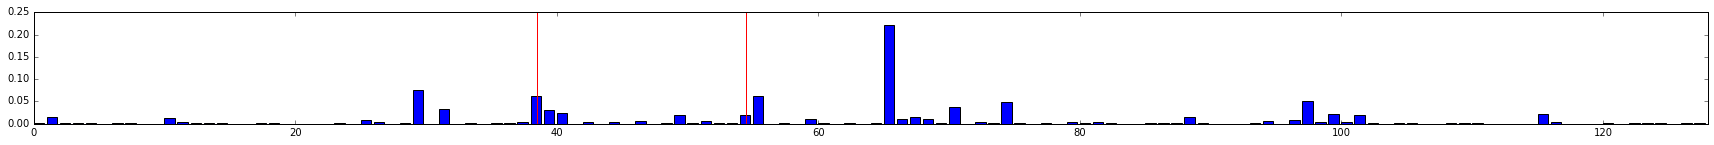

[38] ['drum', 'drums', 'drumset', 'drumkit', 'kit']


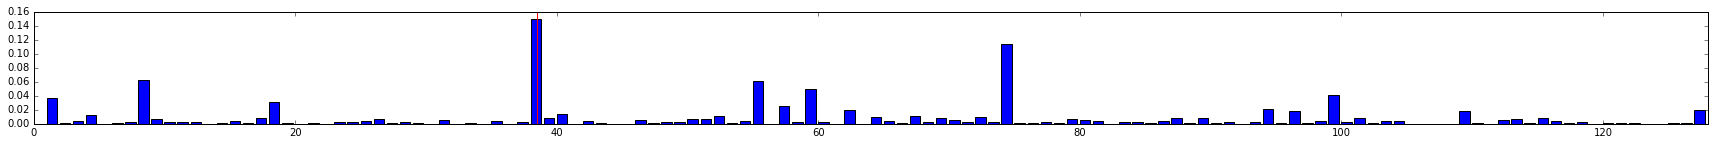

In [104]:
indices = np.arange(nb_classes)
np.random.shuffle(indices)
for i in indices[:10]:
    cur = fingerprints[i].reshape(1,1,32,32)
    cl = model.predict_classes(cur, verbose=0)
    print(cl, synsets[cl[0]])
    plt.figure(figsize=(30,2))
    for label in labels[i]:
        plt.axvline(label+.5,c='red')
    plt.bar(np.arange(nb_classes), model.predict(cur, verbose=0)[0])
    plt.xlim([0,nb_classes])
    plt.show()

['drip']


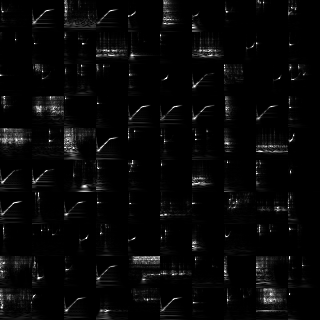

['bird']


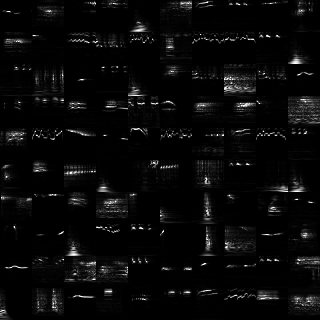

In [49]:
samples_per_class = 100
for j in [36,13]:
    print(synsets[j])
    i = j * samples_per_class
    subset = X_train[i:i+samples_per_class].reshape(-1, img_rows, img_cols)
    show_array(255 * make_mosaic(subset, n=10))